In [36]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import os
os.chdir('..')

# import the necessary package
from adbench.datasets.data_generator import DataGenerator
from adbench.myutils import Utils

datagenerator = DataGenerator()
utils = Utils()

In [37]:
from adbench.baseline.PyOD import PYOD
from adbench.baseline.DevNet.run import DevNet
from adbench.baseline.Supervised import supervised
from adbench.baseline.REPEN.run import REPEN
from adbench.baseline.DevNet.run import DevNet
from adbench.baseline.PReNet.run import PReNet
from adbench.baseline.FEAWAD.run import FEAWAD
from adbench.baseline.DAGMM.run import DAGMM # Unsup
from adbench.baseline.DeepSAD.src.run import DeepSAD # Semi
from adbench.baseline.GANomaly.run import GANomaly


# dataset and model list / dict
# dataset_list = ['1_ALOI', '6_cardio', '25_musk', '18_Ionosphere', '29_Pima']

dataset_list = ['29_Pima']

#m#odel_dict = {'DeepSAD':DeepSAD, 'XGBOD':PYOD, 'CatB': supervised, 'COPOD': PYOD, 'ECOD': PYOD, 'RF': supervised, 'SVM': supervised, 'IForest':PYOD, 'PReNet':PReNet, 'DAGMM':DAGMM, }
model_dict = {'GANomaly': GANomaly, 'XGBOD': PYOD, 'CatB': supervised, 'COPOD': PYOD, 'ECOD': PYOD, 'PReNet':PReNet}

# save the results
df_AUCROC = pd.DataFrame(data=None, index=dataset_list, columns = model_dict.keys())
df_AUCPR = pd.DataFrame(data=None, index=dataset_list, columns = model_dict.keys())

In [38]:
df_results = pd.DataFrame(columns=['Model', 'AUCROC', 'AUCPR'])

# seed for reproducible results
seed = 42

for dataset in dataset_list:
    '''
    la: ratio of labeled anomalies, from 0.0 to 1.0
    realistic_synthetic_mode: types of synthetic anomalies, can be local, global, dependency or cluster
    noise_type: inject data noises for testing model robustness, can be duplicated_anomalies, irrelevant_features or label_contamination
    '''
    
    # import the dataset
    datagenerator.dataset = dataset # specify the dataset name
    data = datagenerator.generator(la=0.1, realistic_synthetic_mode=None, noise_type=None) # only 10% labeled anomalies are available
    
    for name, clf in model_dict.items():
        
        clf = clf(seed=seed, model_name=name)
        clf = clf.fit(X_train=data['X_train'], y_train=data['y_train'])

        if name =="DAGMM":
            score = clf.predict_score(data['X_train'], data['X_test'])
        else:
            score = clf.predict_score(data['X_test'])

        # evaluation
        result = utils.metric(y_true=data['y_test'], y_score=score)
        
        # save results
        new_row = pd.DataFrame({
            'Model': [name],
            'AUCROC': [result['aucroc']],
            'AUCPR': [result['aucpr']]
        })
        df_results = pd.concat([df_results, new_row], ignore_index=True)
        
        df_AUCROC.loc[dataset, name] = result['aucroc']
        df_AUCPR.loc[dataset, name] = result['aucpr']


generating duplicate samples for dataset 29_Pima...
current noise type: None
{'Samples': 1000, 'Features': 8, 'Anomalies': 356, 'Anomalies Ratio(%)': 35.6}
best param: None
Learning rate set to 0.008847
0:	learn: 0.6789970	total: 3.43ms	remaining: 3.42s
1:	learn: 0.6656723	total: 8.35ms	remaining: 4.17s
2:	learn: 0.6514183	total: 14.2ms	remaining: 4.73s
3:	learn: 0.6388796	total: 19.6ms	remaining: 4.88s
4:	learn: 0.6262640	total: 26.9ms	remaining: 5.35s
5:	learn: 0.6138876	total: 31.6ms	remaining: 5.23s
6:	learn: 0.6021063	total: 36.3ms	remaining: 5.15s
7:	learn: 0.5907649	total: 43.6ms	remaining: 5.41s
8:	learn: 0.5795462	total: 48.5ms	remaining: 5.34s
9:	learn: 0.5677055	total: 53ms	remaining: 5.25s
10:	learn: 0.5571902	total: 57.4ms	remaining: 5.16s
11:	learn: 0.5465955	total: 60.7ms	remaining: 5s
12:	learn: 0.5361575	total: 67.4ms	remaining: 5.12s
13:	learn: 0.5259418	total: 72.1ms	remaining: 5.08s
14:	learn: 0.5162900	total: 75.8ms	remaining: 4.98s
15:	learn: 0.5070042	total: 83.2

In [39]:
# # Display the results
df_results = df_results.sort_values(by='AUCROC', ascending=False).reset_index(drop=True)

df_results

,Model,AUCROC,AUCPR
0,CatB,0.771536,0.625059
1,PReNet,0.757494,0.641025
2,XGBOD,0.702629,0.586728
3,COPOD,0.656143,0.541231
4,GANomaly,0.611690,0.499753
5,ECOD,0.592756,0.486831


In [40]:
# pareto module
from test_ensemble_learning.pareto_front import ParetoAnalysis

# Define the criteria and preferences
criteria = ['AUCPR', 'AUCROC'] 
maximize = [True, True]  # Maximize both criteria

# pareto
pareto = ParetoAnalysis(df_results, criteria, maximize)

# Identify the Pareto fronts
pareto.identify_pareto_fronts()

# Access the fronts for further use
fronts = pareto.fronts

# Combine the models of the first two fronts
if len(fronts) >= 2:
    indices_fronts_0_1 = fronts[0] + fronts[1]
else:
    indices_fronts_0_1 = fronts[0]

models_fronts_0_1 = df_results.iloc[indices_fronts_0_1]
print("Models from the first two Pareto fronts:")
print(models_fronts_0_1)

Models from the first two Pareto fronts:
    Model    AUCROC     AUCPR
0    CatB  0.771536  0.625059
1  PReNet  0.757494  0.641025
2   XGBOD  0.702629  0.586728


In [41]:
# Sorting of models from the first two fronts
# Sort Pareto fron by AUCROC and AUCPR
models_sorted = models_fronts_0_1.sort_values(by=['AUCROC', 'AUCPR'], ascending=[False, False]).reset_index(drop=True)

# Select the top 2 models from the Pareto front
top2_models_df = models_sorted.head(2)

print("The best models selected for ensemble learning :")
print(top2_models_df)

The best models selected for ensemble learning :
    Model    AUCROC     AUCPR
0    CatB  0.771536  0.625059
1  PReNet  0.757494  0.641025


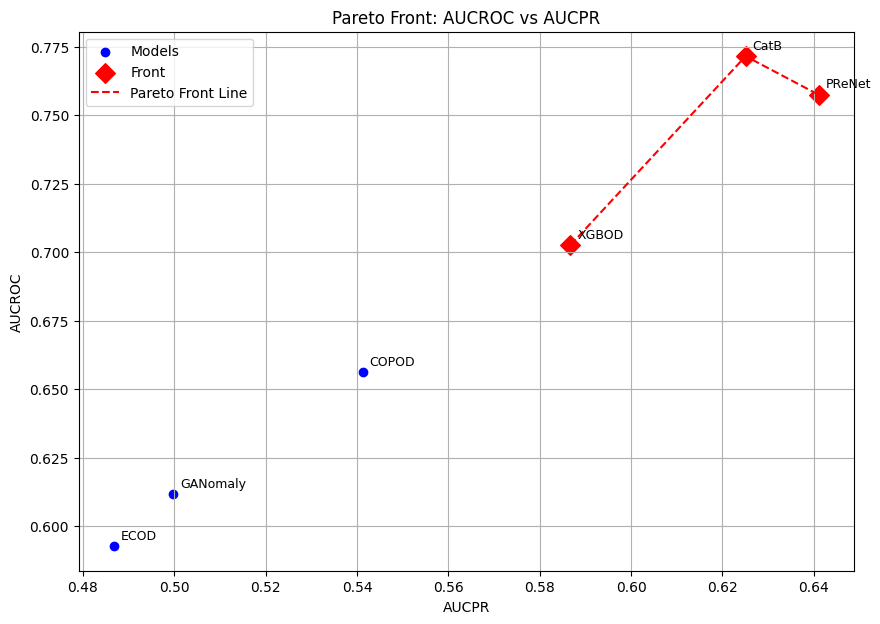

In [42]:
%matplotlib inline

# Plot the Pareto fronts, specifying the fronts to plot

pareto.plot_pareto_fronts(labels=['AUCPR', 'AUCROC'], title="Pareto Front: AUCROC vs AUCPR",
                          annotate=True, fronts_to_plot=[0, 1])


In [43]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import pandas as pd
import numpy as np

# Concatenate existing training and test data
X = np.concatenate((data['X_train'], data['X_test']))
y = np.concatenate((data['y_train'], data['y_test']))

# Split into training, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=seed)

print(f"Taille de X_train: {X_train.shape}")
print(f"Taille de X_val: {X_val.shape}")
print(f"Taille de X_test: {X_test.shape}")


Taille de X_train: (600, 8)
Taille de X_val: (200, 8)
Taille de X_test: (200, 8)


In [44]:

# Initialize AdaBoost with a base estimator
ada_clf = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1),  # Example base estimator, can be replaced with other compatible models
    n_estimators=50,
    learning_rate=1.0,
    random_state=seed
)

# Fit AdaBoost model
ada_clf.fit(X_train, y_train)

# Predict on validation set
val_preds = ada_clf.predict_proba(X_val)[:, 1]

# Predict on test set
test_preds = ada_clf.predict_proba(X_test)[:, 1]


In [45]:

# Calculate AUCROC
val_aucroc = roc_auc_score(y_val, val_preds)
test_aucroc = roc_auc_score(y_test, test_preds)

# Calculate AUCPR
precision, recall, _ = precision_recall_curve(y_val, val_preds)
val_aucpr = auc(recall, precision)
precision, recall, _ = precision_recall_curve(y_test, test_preds)
test_aucpr = auc(recall, precision)

# Print validation and test performance
print("Validation performance of the AdaBoost model:")
print(f"AUCROC: {val_aucroc}")
print(f"AUCPR: {val_aucpr}")

print("Test performance of the AdaBoost model:")
print(f"AUCROC: {test_aucroc}")
print(f"AUCPR: {test_aucpr}")


Validation performance of the AdaBoost model:
AUCROC: 0.7039741847826088
AUCPR: 0.22287608978263118
Test performance of the AdaBoost model:
AUCROC: 0.5804597701149424
AUCPR: 0.1411980042916671


In [46]:
# Add the AdaBoost model's results to df_results
new_row = pd.DataFrame({
    'Model': ['AdaBoost Model'],
    'AUCROC': [test_aucroc],
    'AUCPR': [test_aucpr]
})
df_results = pd.concat([df_results, new_row], ignore_index=True)


In [47]:
# Comparison between the meta-model and individual models
df_results = df_results.sort_values(by='AUCROC', ascending=False).reset_index(drop=True)

df_results

,Model,AUCROC,AUCPR
0,CatB,0.771536,0.625059
1,PReNet,0.757494,0.641025
2,XGBOD,0.702629,0.586728
3,COPOD,0.656143,0.541231
4,GANomaly,0.611690,0.499753
5,ECOD,0.592756,0.486831
6,AdaBoost Model,0.580460,0.141198
